In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload

%autoreload 2

%matplotlib notebook
sns.set()

In [58]:
import galsim

from mdetsims import Sim
from metadetect.detect import MEDSifier
from mdetsims.defaults import TEST_METACAL_MOF_CONFIG
from mdetsims.metacal import get_fofs, MOFFitter
from mdetsims.metacal.util import get_masked_frac

In [4]:
des_sim = Sim(
    rng=np.random.RandomState(seed=100),
    g1=0.02,
    gal_type='wldeblend',
    scale=0.263,
    psf_type='gauss',
    n_coadd=30,
    n_coadd_psf=1,
    gal_kws={'survey_name': 'DES'})

In [5]:
mbobs = des_sim.get_mbobs()

In [26]:
mfier = MEDSifier(
    mbobs=mbobs,
    sx_config=TEST_METACAL_MOF_CONFIG['sx'],
    meds_config=TEST_METACAL_MOF_CONFIG['meds'])

In [27]:
mbmeds = mfier.get_multiband_meds()

In [100]:
res = get_fofs(mfier.cat, TEST_METACAL_MOF_CONFIG['fofs'])

100%|██████████| 41/41 [00:00<00:00, 20188.60it/s]


In [101]:
n_fofs = np.max(res[1]['fofid'])

In [103]:
for fofid in range(n_fofs):
    msk = res[1]['fofid'] == fofid
    if np.sum(msk) > 2:
        inds = res[1]['number'][msk] - 1
        list_of_mbobs = []
        for ind in inds:
            o = mbmeds.get_mbobs(ind)
            o[0].meta['Tsky'] = 1
            o.meta['masked_frac'] = get_masked_frac(o)
            o[0].meta['magzp_ref'] = 26.5
            o.meta['id'] = ind + 1
            o.meta['fofid'] = fofid
            list_of_mbobs.append(o)

In [104]:
list_of_mbobs

[[[<ngmix.observation.Observation at 0x12926c278>]],
 [[<ngmix.observation.Observation at 0x12926c3c8>]],
 [[<ngmix.observation.Observation at 0x12926c5f8>]],
 [[<ngmix.observation.Observation at 0x12926c198>]]]

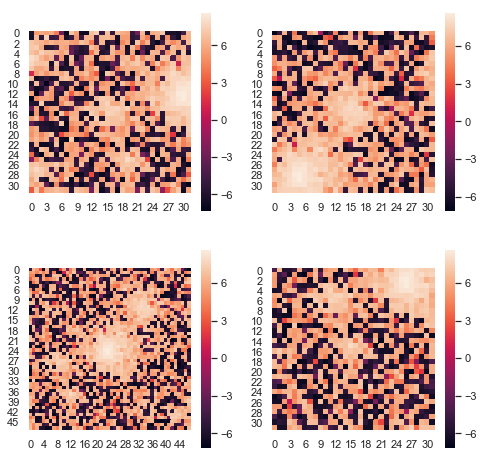

In [123]:
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(2, 2, 1)
sns.heatmap(np.arcsinh(list_of_mbobs[0][0][0].image), square=True, ax=ax)

ax = fig.add_subplot(2, 2, 2)
sns.heatmap(np.arcsinh(list_of_mbobs[1][0][0].image), square=True, ax=ax)

ax = fig.add_subplot(2, 2, 3)
sns.heatmap(np.arcsinh(list_of_mbobs[2][0][0].image), square=True, ax=ax)

ax = fig.add_subplot(2, 2, 4)
sns.heatmap(np.arcsinh(list_of_mbobs[3][0][0].image), square=True, ax=ax)

In [107]:
fitter = MOFFitter(TEST_METACAL_MOF_CONFIG, 1, np.random.RandomState(seed=10))

In [112]:
od, ed = fitter.go(list_of_mbobs)

In [109]:
mof_fitter = fitter.get_mof_fitter()

In [110]:
rs = mof_fitter.make_corrected_obs()

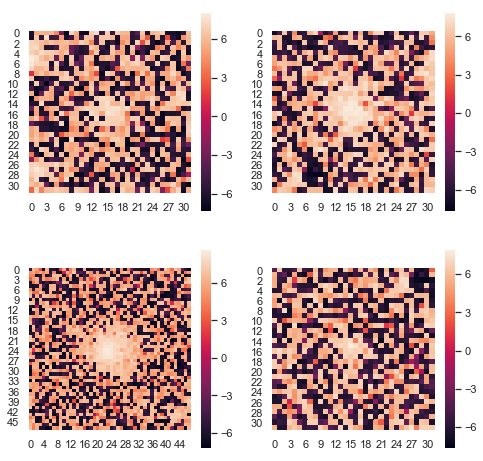

In [124]:
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(2, 2, 1)
sns.heatmap(np.arcsinh(rs[0][0][0].image), square=True, ax=ax)

ax = fig.add_subplot(2, 2, 2)
sns.heatmap(np.arcsinh(rs[1][0][0].image), square=True, ax=ax)

ax = fig.add_subplot(2, 2, 3)
sns.heatmap(np.arcsinh(rs[2][0][0].image), square=True, ax=ax)

ax = fig.add_subplot(2, 2, 4)
sns.heatmap(np.arcsinh(rs[3][0][0].image), square=True, ax=ax)

In [125]:
from ngmix.bootstrap import MaxMetacalBootstrapper

In [128]:
bt = MaxMetacalBootstrapper(rs[0], verbose=True)